In [1]:
%load_ext autoreload
%autoreload 2
# folder path
import os
dir_path = "C://Users//vnarv//PycharmProjects//scoring_SDA/data/"
os.chdir("C://Users//vnarv//PycharmProjects//scoring_SDA/")

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
)
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from conf.config import data_inputs_paths as data_inputs


##################### base line model ###########
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from conf.config import model_config
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV
# Package xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
import time

from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, chi2, mutual_info_classif
# Package pour représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [3]:
from src.preprocessing.preprocessing_x import PreprocessData
from src.preprocessing.transform_data import TransformData
from src.preprocessing.split_scale import SplitandScale
from conf.config import data_inputs_paths as data_inputs

In [4]:
td = TransformData()
all_x = td.transform_data(data_inputs)
all_x = all_x.set_index(['FIPS_CODE', 'STATE'])


========== File name <_io.BufferedReader name='C:\\Users\\vnarv\\PycharmProjects\\scoring_SDA\\data//Education.xls'>

Educational attainment for adults age 25 and older for the U.S., States, and counties, 1970-2019

========== File name <_io.BufferedReader name='C:\\Users\\vnarv\\PycharmProjects\\scoring_SDA\\data//PopulationEstimates.xls'>

Population estimates for the U.S., States, and counties, 2010-19 (see the second tab in this workbook for variable name descriptions)

========== File name <_io.BufferedReader name='C:\\Users\\vnarv\\PycharmProjects\\scoring_SDA\\data//PovertyEstimates.xls'>

Poverty estimates for the U.S., States, and counties, 2019

========== File name <_io.BufferedReader name='C:\\Users\\vnarv\\PycharmProjects\\scoring_SDA\\data//Unemployment.xls'>

Unemployment and median household income for the U.S., States, and counties, 2000-19

Nb of counties found: 3112 / 3152
Missing county(ies): ['02901', '02902', '02903', '02904', '02905', '02906', '02907', '02908', 

In [5]:
prepro = PreprocessData(data_inputs)
X_prepro = prepro.run_preprocessing(
    all_x.copy(deep=True),
    do_save=True,
    feat_to_keep=["CIVILIAN_LABOR_FORCE_2019"],
    abs_corr_thresh=0.9
   )

Save mode: True

 Features with < 300 unique values
CI90LB04P_2019              1
PCTPOV04_2019               1
POV04_2019                  1
CI90LB04_2019               1
CI90UB04P_2019              1
CI90UB04_2019               1
METRO_2013                  2
ECONOMIC_TYPOLOGY_2015      6
RESIDUAL_2011              92
UNEMPLOYMENT_RATE_2018     93
UNEMPLOYMENT_RATE_2019     94
RESIDUAL_2018             101
UNEMPLOYMENT_RATE_2000    102
UNEMPLOYMENT_RATE_2017    103
UNEMPLOYMENT_RATE_2007    108
UNEMPLOYMENT_RATE_2006    109
UNEMPLOYMENT_RATE_2004    110
UNEMPLOYMENT_RATE_2005    111
RESIDUAL_2016             112
UNEMPLOYMENT_RATE_2001    113
UNEMPLOYMENT_RATE_2016    114
RESIDUAL_2017             116
RESIDUAL_2019             118
UNEMPLOYMENT_RATE_2003    118
UNEMPLOYMENT_RATE_2015    119
UNEMPLOYMENT_RATE_2002    120
UNEMPLOYMENT_RATE_2008    122
UNEMPLOYMENT_RATE_2014    136
UNEMPLOYMENT_RATE_2013    156
UNEMPLOYMENT_RATE_2012    159
UNEMPLOYMENT_RATE_2011    173
UNEMPLOYMENT_RATE_

saved


In [6]:
X_prepro.head()

,,RURAL_URBAN_CONTINUUM_CODE_2013_2.0,RURAL_URBAN_CONTINUUM_CODE_2013_3.0,RURAL_URBAN_CONTINUUM_CODE_2013_4.0,RURAL_URBAN_CONTINUUM_CODE_2013_5.0,RURAL_URBAN_CONTINUUM_CODE_2013_6.0,RURAL_URBAN_CONTINUUM_CODE_2013_7.0,RURAL_URBAN_CONTINUUM_CODE_2013_8.0,RURAL_URBAN_CONTINUUM_CODE_2013_9.0,URBAN_INFLUENCE_CODE_2013_2.0,URBAN_INFLUENCE_CODE_2013_3.0,...,R_DEATH_2017,R_BIRTH_2019,R_DEATH_2018,R_DEATH_2013,R_DEATH_2015,R_DEATH_2012,R_DEATH_2016,R_DEATH_2014,R_BIRTH_2012,R_BIRTH_2013
FIPS_CODE,STATE,,,,,,,,,,,,,,,,,,,,,
01001,AL,True,False,False,False,False,False,False,False,True,False,...,10.358573,11.202671,9.339812,10.612595,10.64169,10.165092,9.93579,10.454297,11.163449,10.412013
01003,AL,False,True,False,False,False,False,False,False,True,False,...,9.992336,10.446871,10.744094,9.869361,10.434644,10.007884,9.850441,10.084554,11.112202,11.219905
01005,AL,False,False,False,False,True,False,False,False,False,False,...,11.577026,10.331329,13.152372,10.904521,12.519326,10.493487,10.75083,11.472845,11.007155,10.423983
01007,AL,False,False,False,False,False,False,False,False,False,False,...,11.166253,10.723621,11.710488,12.171373,11.746714,10.393729,10.675053,10.959755,10.834141,11.418961
01009,AL,False,False,False,False,False,False,False,False,False,False,...,12.508566,11.263268,11.90744,10.121616,11.00372,10.196283,11.302382,10.19584,12.367553,11.232736


In [7]:
ss = SplitandScale(data_inputs)
X_train, X_test, y_train, y_test = ss.run_split_scale()


 df_x_train = (2489, 109) / df_x_test = (623, 109)

 df_y_train = (2489, 1) / df_y_test = (623, 1)

 Class distribution y_train :
0    0.82724
1    0.17276
Name: TARGET, dtype: float64

 Class distribution y_test :
0    0.826645
1    0.173355
Name: TARGET, dtype: float64
Using scaler: robust


In [8]:
# parameters

# define random state
seed = 123

# define class weights
class_weight = model_config["class_weight"]
cw = compute_class_weight(
    class_weight,
    classes=np.unique(y_train["TARGET"]),
    y=y_train["TARGET"],
)
cw_dict = dict(enumerate(cw))
print(cw_dict)



models = {
    "LogisticRegression":
    LogisticRegression(
            max_iter=1000,
            random_state=seed,
            class_weight=cw_dict
    ),
    "SVM":
    SVC(
        gamma='scale',
        class_weight=cw_dict
    ),
    "BaggingClassifier":
        BaggingClassifier(
            n_estimators=300,
            random_state=seed
    ),
    "BalancedBaggingClassifier":
    BalancedBaggingClassifier(
            random_state=seed
    ),
    "RandomForestClassifier":
        RandomForestClassifier(
            n_estimators=300,
            class_weight=cw_dict,
            max_depth=3,
            random_state=seed,
        ),
    "GradientBoosting":
        GradientBoostingClassifier(
            n_estimators=300,
            max_depth=3,
            random_state=seed
        ),
    "XGBClassifier":
        XGBClassifier(
            #use_label_encoder=False,
            n_estimators=80,
            eval_metric='logloss',
            random_state=seed,
            learning_rate=0.1
        )
}

{0: 0.6044196211753279, 1: 2.894186046511628}


In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def calculate_precision_recall_curve(model, trainX, trainy, testX, testy):
     
    # metrics
    md_precision_train, md_recall_train, md_f1_train, md_auc_train = _metrics(model, trainX, trainy)
    md_precision_test, md_recall_test, md_f1_test, md_auc_test = _metrics(model, testX, testy)
   
    print('\n >>f1 score: %.3f (train) %.3f (test)\n' % (md_f1_train, md_f1_test))    
    print('\n >>auc: %.3f (train) %.3f (test)' % (md_auc_train, md_auc_test))
    
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(md_recall_train, md_precision_train, marker='.', label='train')
    pyplot.plot(md_recall_test, md_precision_test, marker='.', label='test')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    
def gridSearch_best_model(grid, estimator_gs, X_train_class, y_train_class, X_test_class, y_test_class):
 
    cv_grid_search = GridSearchCV(
    estimator=estimator_gs,
    param_grid=grid,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    cv=10,
    verbose=2
    )
    
    # Entrainement et évaluation du modèle
    gs_fit = fit_model(X_train_class, y_train_class, cv_grid_search)
    
    calculate_precision_recall_curve(gs_fit, X_train_class, y_train_class, X_test_class, y_test_class)
    
    print(cv_grid_search.best_estimator_)
    print(cv_grid_search.best_score_)
    print(cv_grid_search.best_params_)

    return cv_grid_search.best_estimator_

def make_confusion_matrix(y_true, y_pred, alias, labels=None):
    if labels is None:
        labels = ['Republicans', 'Democrats']
    z = confusion_matrix(y_true, y_pred)
    x = labels
    y = labels

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='RdBu')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                      yaxis={"title": "Real value"},
                      )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black", size=12),
                            x=0.5,
                            y=-0.15,
                            text="Predicted value",
                            showarrow=False,
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black", size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.write_html(f"images/confusion_matrix{alias}.html")
    fig.show()
    
def compute_RFECV(X,
                  y,
                  estimator=RandomForestClassifier(class_weight=cw_dict),
                  min_features=20):
    # Instanciation de la RFECV()
    rfecv_selector = RFECV(estimator=estimator,
                           min_features_to_select=min_features,
                           scoring=make_scorer(f1_score),
                           n_jobs=-1,
                           step=1,
                           cv=5
                           )

    # Entraîner le modèle
    rfecv_selector.fit(X, y)
    mean_test_f1_score = rfecv_selector.cv_results_["mean_test_score"]
    n_features_selected = rfecv_selector.n_features_
    min_features_to_select = rfecv_selector.min_features_to_select
    n_features_in_rfecv = rfecv_selector.n_features_in_

    fig = px.line(y=mean_test_f1_score,
                  x=range(min_features_to_select, len(mean_test_f1_score) + min_features_to_select),
                  labels={
                      "x": "Nombre de variables sélectionnées",
                      "y": "Score moyen de cross-validaion"
                  },
                  title=f"Résultats RFECV avec {rfecv_selector.cv} k-fold"
                  )
    fig.add_vline(x=n_features_selected, line_width=3, line_dash="dash", line_color="#011C5D")
    fig.add_vrect(x0=30, x1=n_features_in_rfecv, line_width=0, fillcolor="#D38F00", opacity=0.2)
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.show()
    fig.write_image("images/RFE_random_forest.png")

    # Récupérer la liste des variables issues de RFECV et transformer là en liste
    rfe_features = rfecv_selector.get_feature_names_out().tolist()
    return rfe_features

def fit_model(X, y, estimator, **kwargs):
    model = Pipeline(
        steps=[
            ("estimator", estimator)
        ]
    )
    return model.fit(X, y, **kwargs)

# SélectionneZ les k variables numériques les plus liées à la cible
def feature_selection_KBest(X, y, nb_features):
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    # sur le base du critère d'information mutuelle.
    mic_selector = SelectKBest(score_func=mutual_info_classif, k=nb_features)
    mic_selector.fit(X[num_cols], y)

    # Liste des variables retenues
    mic_features = np.array(num_cols)[mic_selector.get_support()].tolist()
    print(f"%s most important features according to <<Kbest method>>" % nb_features)
    print(mic_features)
    return mic_features


def evaluate_model(model, X, y):
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring=make_scorer(f1_score), cv=cv, n_jobs=-1)
    return scores


def _metrics(model, X, y):
    # predict proba
    md_proba = model.predict_proba(X)
    #keep only positive outcome
    md_proba = md_proba[:, 1]
    #predict class value
    y_hat = model.predict(X)
    
    #calculate precision and recall for each threshold
    md_precision, md_recall, _ = precision_recall_curve(y, md_proba)
    # calculate f1 and auc
    md_f1, md_auc = f1_score(y, y_hat), auc(md_recall, md_precision)
    metrics = md_precision, md_recall, md_f1, md_auc

    return metrics

# Base line model

F1 score (train with k fold) 0.668

 >>f1 score: 0.732 (train) 0.705 (test)


 >>auc: 0.844 (train) 0.825 (test)


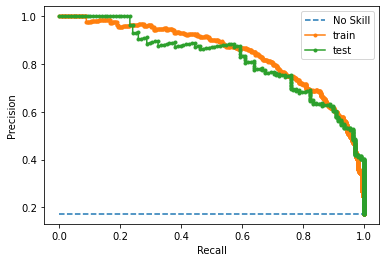

In [10]:
# lr with all variables
lr = LogisticRegression(class_weight=cw_dict,
                  max_iter=1000,
                  random_state=seed)
lr.fit(X_train, y_train["TARGET"])
lr_scores = evaluate_model(lr, X_train, y_train["TARGET"])
print("F1 score (train with k fold) %.3f" % mean(lr_scores))
calculate_precision_recall_curve(
      lr,
      X_train,
      y_train["TARGET"],
      X_test,
      y_test["TARGET"]
 )

In [11]:
KBest_features = feature_selection_KBest(X_train, y_train["TARGET"], 50)

50 most important features according to <<Kbest method>>
['N_POP_CHG_2010', 'N_POP_CHG_2017', 'GQ_ESTIMATES_2016', 'PERCENT_OF_ADULTS_WITH_LESS_THAN_A_HIGH_SCHOOL_DIPLOMA__1980', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__1990', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__2000', 'PERCENT_OF_ADULTS_WITH_A_BACHELOR_S_DEGREE_OR_HIGHER__2000', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__2015_19', 'RESIDUAL_2011', 'RESIDUAL_2018', 'RESIDUAL_2016', 'RESIDUAL_2017', 'RESIDUAL_2019', 'RESIDUAL_2010', 'RESIDUAL_2015', 'RESIDUAL_2013', 'RESIDUAL_2014', 'RESIDUAL_2012', 'INTERNATIONAL_MIG_2016', 'DOMESTIC_MIG_2010', 'NET_MIG_2010', 'DOMESTIC_MIG_2011', 'NET_MIG_2011', 'DOMESTIC_MIG_2012', 'DOMESTIC_MIG_2013', 'NET_MIG_2013', 'DOMESTIC_MIG_2014', 'NET_MIG_2019', 'DOMESTIC_MIG_2015', 'DOMESTIC_MIG_2016', 'DOMESTIC_MIG_2018', 'DOMESTIC_MIG_2017', 'R_INTERNATIONAL_MIG_2019', 'R_INTERNATIONAL_MIG_2013', 'R_INTERNATIONAL_MIG_2012', 'R_INTERNATIONAL_MIG_2011', 'R_INTERNATIONAL_M

F1 score (train with kfold)  0.608

 >>f1 score: 0.637 (train) 0.639 (test)


 >>auc: 0.755 (train) 0.773 (test)


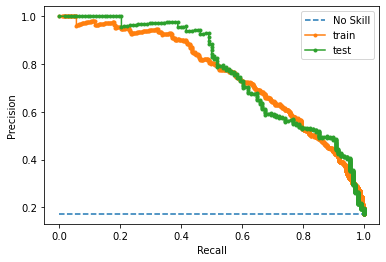

In [12]:
# lr with only a few variables
lr = LogisticRegression(class_weight=cw_dict,
                  max_iter=1000,
                  random_state=seed)
lr.fit(X_train[KBest_features], y_train["TARGET"])
lr_scores = evaluate_model(lr, X_train[KBest_features], y_train["TARGET"])
print("F1 score (train with kfold)  %.3f" % mean(lr_scores))

calculate_precision_recall_curve(
      lr,
      X_train[KBest_features],
      y_train["TARGET"],
      X_test[KBest_features],
      y_test["TARGET"]
 )

# Exploring RFE

###  - RFE with different base algorithms

In [13]:
# option 1 : definir le nb de features et appliquer decision trees
# get a list of models to evaluate
def get_models(weights=cw_dict, n_features=50):
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['lr'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['cart'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['rf'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['gbm'] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring=make_scorer(f1_score), cv=cv, n_jobs=-1)
    return scores


# get the models to evaluate
models_rfe = get_models()
# evaluate the models and store results
results, names = list(), list()
start = time.time()
for name, model in models_rfe.items():
    scores = evaluate_model(model, X_train, y_train["TARGET"])
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
end = time.time()
delta = (end - start) / 60
print(f"modelisation took {delta:.2} minutes")

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.savefig("images/model_performance_RFE")

>lr 0.643 (0.050)
>cart 0.659 (0.059)



KeyboardInterrupt



There seems to be almost no difference between the different methods

## - Exploring RFE with CV integrated for feature selection. Then model with different algorithms 

In [ ]:
# fit random forest with RFE to select variables
rfe_RF_features = compute_RFECV(X_train,
                                y_train["TARGET"],
                                min_features=20)
print('>The selected features by RFE are : \n %s' % (rfe_RF_features))

In [ ]:
results_train, results_test, names = list(), list(), list()
# Boucler sur chacun des modèles
for name, model in models.items():
    fit_m = fit_model(X_train[rfe_RF_features], y_train["TARGET"], model)
    scores_train = evaluate_model(fit_m, X_train[rfe_RF_features], y_train["TARGET"])
    y_pred_test = fit_m.predict(X_test[rfe_RF_features])
    F1_test = f1_score(y_test["TARGET"], y_pred_test)
    results_train.append(scores_train)
    results_test.append(F1_test)
    names.append(name)
    print('>%s %.3f (train kbest) %.3f (test)' % (name, mean(scores_train), F1_test))

# 10 vars exp
#>LogisticRegression 0.646 (train) 0.701 (test)
#>BaggingClassifier 0.686 (train) 0.695 (test)
#>BalancedBaggingClassifier 0.663 (train) 0.675 (test)
#>RandomForestClassifier 0.640 (train) 0.680 (test)
#>GradientBoosting 0.675 (train) 0.714 (test)
#>XGBClassifier 0.686 (train) 0.663 (test)

# Boruta

In [ ]:
from boruta import BorutaPy
rf_boruta = RandomForestClassifier(class_weight=cw_dict, n_jobs=-1, max_depth=3)

# Compléter les paramètres de la méthode boruta
set_seed = 1204
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=set_seed)

# Entraîner boruta
X_boruta = X_train.values
y_boruta = y_train["TARGET"].values.ravel()
boruta_selector.fit(X_boruta, y_boruta)

In [ ]:
# Récupération des variables issues de boruta
boruta_features = X_train.columns[boruta_selector.support_]
boruta_features

In [ ]:
results_train_boruta, results_test_boruta, names_boruta = list(), list(), list()
# Boucler sur chacun des modèles
for name, model in models.items():
    fit_m = fit_model(X_train[boruta_features], y_train["TARGET"], model)
    scores_train = evaluate_model(fit_m, X_train[boruta_features], y_train["TARGET"])
    y_pred_test = fit_m.predict(X_test[boruta_features])
    F1_test = f1_score(y_test["TARGET"], y_pred_test)
    results_train_boruta.append(scores_train)
    results_test_boruta.append(F1_test)
    names_boruta.append(name)
    print('>%s %.3f (train) %.3f (test)' % (name, mean(scores_train), F1_test))

# Modelisation with all variables 

In [ ]:
results_train, results_test, names = list(), list(), list()
# Boucler sur chacun des modèles
for name, model in models.items():
    fit_m = fit_model(X_train, y_train["TARGET"], model)
    scores_train_all = evaluate_model(fit_m, X_train, y_train["TARGET"])
    y_pred_test = fit_m.predict(X_test)
    F1_test = f1_score(y_test["TARGET"], y_pred_test)
    results_train_amm.append(scores_train)
    results_test_all.append(F1_test)
    names.append(name)
    print('>%s %.3f (train k fold) %.3f (test)' % (name, mean(scores_train_all), F1_test))
    
# >LogisticRegression 0.713 (train k fold) 0.693 (test)
# >BaggingClassifier 0.714 (train k fold) 0.706 (test)
# >BalancedBaggingClassifier 0.689 (train k fold) 0.614 (test)
# >RandomForestClassifier 0.640 (train k fold) 0.622 (test)
# >GradientBoosting 0.722 (train k fold) 0.674 (test)
# >XGBClassifier 0.729 (train k fold) 0.653 (test)

In [ ]:
len(rfe_RF_features)

#  Grid search 

In [ ]:
params_grid = {
#     "LogisticRegression":
#         {'solver': ['liblinear', 'lbfgs'],
#          'class_weight': [cw_dict, 'balanced']
#          },
#     "BaggingClassifier":
#         {'n_estimators': [5, 10, 15 ],
#          'max_features': [1, 3],
#          #'max_samples': [1, 2, 3]
#        } ,
    "RandomForestClassifier":
        {'n_estimators': [100, 200],
         'min_samples_split':[5, 15],
         #'max_depth': [3, 10 ],
         'class_weight': ['balanced_subsample',
                          cw_dict,
                          'balance'
                         ]
        },
#     "XGBClassifier":
#        {'gamma': [0, 0.1, 0.3],
#               'learning_rate': [0.01, 0.1, 0.3],
#               'max_depth': [3, 5, 6],
#               'n_estimators': [50, 80, 100, 120],
#               #'reg_alpha': [0, 0.1, 0.4, 1],
#               #'reg_lambda': [0, 0.1, 0.4, 1]
#              }
}


estimators = {
#     "LogisticRegression":
#         LogisticRegression(
#             max_iter=1000,
#             random_state=seed,
#             class_weight=cw_dict
#         ),
#     "BaggingClassifier":
#         BalancedBaggingClassifier(
#             random_state=seed,
#         ),
    "RandomForestClassifier":
        RandomForestClassifier(
            #class_weight=cw_dict,
            random_state=seed,
        ),
#     "XGBClassifier":
#         XGBClassifier(
#             use_label_encoder=False,
#             eval_metric='logloss',
#             random_state=seed,
#         )
}


In [ ]:
for name, model in params_grid.items():
    print(name, model.keys())
    

In [ ]:
print(len(X_train)/5)

In [ ]:
for key in set(params_grid.keys()) & set(estimators.keys()):
    print(key)
    print(params_grid[key])
    print(estimators[key])
    print('>%s:' % (key))
    gridSearch_best_model(params_grid[key],
                          estimators[key],
                          X_train[rfe_RF_features],
                          y_train["TARGET"],
                          X_test[rfe_RF_features],
                          y_test["TARGET"]
                         )



In [ ]:
for key in set(params_grid.keys()) & set(estimators.keys()):
    print(key)
    print(params_grid[key])
    print(estimators[key])
    print('>%s:' % (key))
    gridSearch_best_model(params_grid[key],
                          estimators[key],
                          X_train,
                          y_train["TARGET"],
                          X_test,
                          y_test["TARGET"]
                         )

In [ ]:
for key in set(params_grid.keys()) & set(estimators.keys()):
    print(key)
    print(params_grid[key])
    print(estimators[key])
    print('>%s:' % (key))
    gridSearch_best_model(params_grid[key],
                          estimators[key],
                          X_train[rfe_RF_features],
                          y_train["TARGET"],
                          X_test[rfe_RF_features],
                          y_test["TARGET"]
                         )

